<a href="https://colab.research.google.com/github/TAUforPython/Graph-MachineLearning/blob/main/Hyperbolic%20Graph%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch-geometric geoopt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.3 MB/s eta 0:00:00


Model Architecture:

Hyperbolic Graph Convolutions using Poincaré ball model

Riemannian optimization for hyperbolic parameters

Multi-layer hyperbolic GNN with proper manifold projections

Dropout regularization for better generalization

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import kneighbors_graph
import geoopt
from geoopt.manifolds import PoincareBall
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Simplified Hyperbolic Linear Layer
class HyperbolicLinear(nn.Module):
    def __init__(self, in_features, out_features, manifold, dropout=0.1):
        super().__init__()
        self.manifold = manifold
        self.in_features = in_features
        self.out_features = out_features

        # Use standard linear layer in tangent space
        self.linear = nn.Linear(in_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project to tangent space, apply linear, project back
        x_tangent = self.manifold.logmap0(x)
        x_tangent = self.linear(x_tangent)
        x_tangent = self.dropout(x_tangent)
        x = self.manifold.expmap0(x_tangent)
        return x

# Hyperbolic Graph Convolution Layer (Simplified)
class HyperbolicGraphConv(nn.Module):
    def __init__(self, in_features, out_features, manifold, dropout=0.1):
        super().__init__()
        self.manifold = manifold
        self.linear = HyperbolicLinear(in_features, out_features, manifold, dropout)

    def forward(self, x, edge_index):
        # Simple message passing: aggregate neighbors in hyperbolic space
        row, col = edge_index
        messages = x[col]

        # Aggregate messages (mean aggregation)
        aggregated = torch.zeros_like(x)
        aggregated = aggregated.index_add_(0, row, messages)

        # Count neighbors for normalization
        degree = torch.zeros(x.size(0), device=x.device)
        degree = degree.index_add_(0, row, torch.ones_like(row, dtype=torch.float))
        degree = torch.clamp(degree, min=1).unsqueeze(-1)

        aggregated = aggregated / degree

        # Combine with self-information and transform
        combined = self.manifold.mobius_add(x, aggregated)
        output = self.linear(combined)

        return output

# Complete Hyperbolic GNN Model
class HyperbolicGNN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, curvature=1.0, dropout=0.3):
        super().__init__()
        self.manifold = PoincareBall(c=curvature)

        # Initial projection to hyperbolic space
        self.input_proj = HyperbolicLinear(in_features, hidden_dim, self.manifold, dropout)

        # Hyperbolic graph layers
        self.conv1 = HyperbolicGraphConv(hidden_dim, hidden_dim, self.manifold, dropout)
        self.conv2 = HyperbolicGraphConv(hidden_dim, hidden_dim, self.manifold, dropout)

        # Final classification in tangent space
        self.classifier = nn.Linear(hidden_dim, out_features)

        # Activation
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        # Initial projection to hyperbolic space
        x = self.manifold.expmap0(x)
        x = self.input_proj(x)
        x = self.activation(self.manifold.logmap0(x))
        x = self.manifold.expmap0(x)

        # Hyperbolic graph convolutions
        x = self.conv1(x, edge_index)
        x = self.activation(self.manifold.logmap0(x))
        x = self.dropout(x)
        x = self.manifold.expmap0(x)

        x = self.conv2(x, edge_index)
        x = self.activation(self.manifold.logmap0(x))
        x = self.dropout(x)
        x = self.manifold.expmap0(x)

        # Final projection to tangent space for classification
        x_tangent = self.manifold.logmap0(x)
        x_tangent = self.classifier(x_tangent)

        return F.log_softmax(x_tangent, dim=1)

# Data Preparation Functions
def create_graph_from_dataframe(df, k_neighbors=10):
    """Create graph from coordinate data using k-nearest neighbors"""
    positions = np.array([[row['X'], row['Y']] for _, row in df.iterrows()])

    # Create k-nearest neighbors graph
    adj_matrix = kneighbors_graph(positions, k_neighbors, mode='connectivity', include_self=False)

    # Convert to edge index format
    edge_index = []
    rows, cols = adj_matrix.nonzero()
    for i, j in zip(rows, cols):
        edge_index.append([i, j])
        edge_index.append([j, i])  # Add reverse for undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Remove duplicates and self-loops
    edge_index = torch.unique(edge_index, dim=1)

    return edge_index

def prepare_data(df):
    """Prepare data for PyTorch Geometric"""
    # Node features (coordinates, normalized)
    x = torch.tensor(df[['X', 'Y']].values, dtype=torch.float)

    # Normalize features
    x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)

    # Labels (convert to 0/1)
    label_mapping = {'cross': 0, 'point': 1}
    y = torch.tensor([label_mapping[t] for t in df['Type']], dtype=torch.long)

    # Create graph structure
    edge_index = create_graph_from_dataframe(df)

    return x, edge_index, y

# Training Function
def train_model(model, x, edge_index, y, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create train/val split
    indices = torch.randperm(len(y))
    train_size = int(0.8 * len(y))
    train_mask = indices[:train_size]
    val_mask = indices[train_size:]

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(x, edge_index)
        loss = F.nll_loss(out[train_mask], y[train_mask])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(x, edge_index)
            val_pred = val_out[val_mask].argmax(dim=1)
            val_acc = (val_pred == y[val_mask]).float().mean()

        train_losses.append(loss.item())
        val_accuracies.append(val_acc.item())

        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_accuracies, train_mask, val_mask

# Visualization Functions
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(val_accuracies, label='Validation Accuracy', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_original_data(df):
    """Plot original data with true labels"""
    plt.figure(figsize=(12, 8))

    colors = {'cross': 'lightgreen', 'point': 'red'}
    markers = {'cross': 'X', 'point': 'o'}
    sizes = {'cross': 80, 'point': 60}

    for label in df['Type'].unique():
        mask = df['Type'] == label
        plt.scatter(df[mask]['X'], df[mask]['Y'],
                   c=colors[label], marker=markers[label],
                   label=label, s=sizes[label], alpha=0.7,
                   edgecolors='darkgray', linewidths=0.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Original Data - Cross vs Point Classification')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_predictions(df, model, x, edge_index, y):
    """Plot model predictions"""
    model.eval()
    with torch.no_grad():
        predictions = model(x, edge_index).argmax(dim=1).numpy()

    plt.figure(figsize=(15, 6))

    # True labels
    plt.subplot(1, 2, 1)
    colors = {0: 'lightgreen', 1: 'red'}
    markers = {0: 'X', 1: 'o'}
    sizes = {0: 80, 1: 60}
    labels = {0: 'cross', 1: 'point'}

    for label in [0, 1]:
        mask = y.numpy() == label
        plt.scatter(df.iloc[mask]['X'], df.iloc[mask]['Y'],
                   c=colors[label], marker=markers[label],
                   label=labels[label], s=sizes[label], alpha=0.7,
                   edgecolors='darkgray', linewidths=0.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('True Labels')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Predicted labels
    plt.subplot(1, 2, 2)
    for label in [0, 1]:
        mask = predictions == label
        plt.scatter(df.iloc[mask]['X'], df.iloc[mask]['Y'],
                   c=colors[label], marker=markers[label],
                   label=labels[label], s=sizes[label], alpha=0.7,
                   edgecolors='darkgray', linewidths=0.5)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Model Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return predictions

def plot_confusion_matrix(true_labels, pred_labels):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['cross', 'point'],
                yticklabels=['cross', 'point'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_graph_structure(df, edge_index, y, sample_size=300):
    """Visualize the graph structure"""
    if len(df) > sample_size:
        # Sample for better visualization
        indices = np.random.choice(len(df), sample_size, replace=False)
    else:
        indices = np.arange(len(df))

    # Create subgraph positions
    pos = {i: (df.iloc[i]['X'], df.iloc[i]['Y']) for i in indices}

    # Create graph for visualization
    G = nx.Graph()
    for i in indices:
        G.add_node(i, pos=pos[i], label=y[i].item())

    # Add some edges for visualization (limited for clarity)
    edge_count = 0
    max_edges = 500  # Limit for clarity

    for i in range(edge_index.shape[1]):
        if edge_count >= max_edges:
            break
        src, dst = edge_index[0][i].item(), edge_index[1][i].item()
        if src in indices and dst in indices:
            G.add_edge(src, dst)
            edge_count += 1

    plt.figure(figsize=(12, 8))

    # Node colors based on labels
    node_colors = [y[i].item() for i in G.nodes()]

    nx.draw(G, pos,
            node_color=node_colors,
            cmap='coolwarm',
            node_size=30,
            alpha=0.7,
            edge_color='gray',
            width=0.3,
            with_labels=False)

    plt.title('Graph Structure (Blue: Cross, Red: Point)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_hyperbolic_embeddings(model, x, edge_index, y):
    """Plot learned hyperbolic embeddings"""
    model.eval()
    with torch.no_grad():
        # Get embeddings after first layer
        embeddings = model.manifold.expmap0(x)
        embeddings = model.input_proj(embeddings)
        embeddings = model.manifold.logmap0(embeddings)
        embeddings = embeddings.numpy()

    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=y.numpy(), cmap='viridis',
                        alpha=0.7, s=50)

    plt.colorbar(scatter, label='Class (0: cross, 1: point)')
    plt.xlabel('Hyperbolic Embedding Dimension 1')
    plt.ylabel('Hyperbolic Embedding Dimension 2')
    plt.title('Learned Hyperbolic Embeddings')
    plt.grid(True, alpha=0.3)
    plt.show()


Dataset Info:
Total samples: 1672
Class distribution:
Type
cross    1445
point     227
Name: count, dtype: int64
X range: [58, 1940]
Y range: [37, 1749]


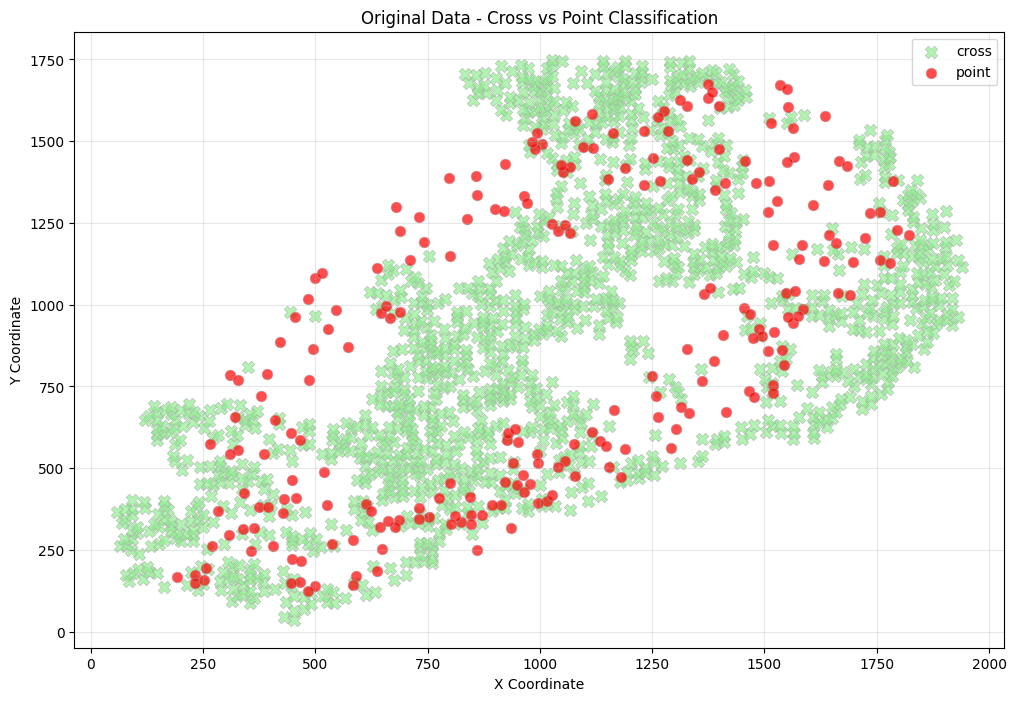


Graph Info:
Nodes: 1672
Edges: 19344
Features: 2


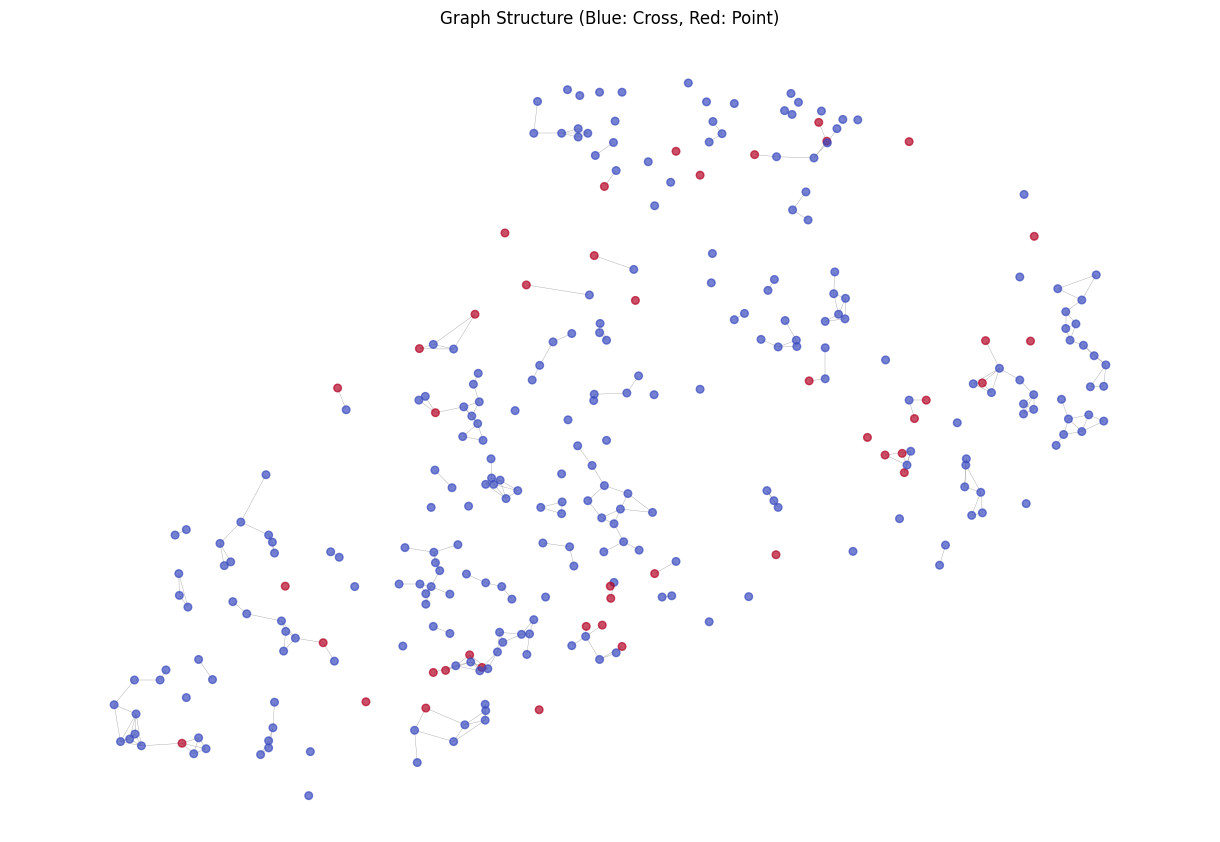


Model Architecture:
HyperbolicGNN(
  (manifold): PoincareBall manifold
  (input_proj): HyperbolicLinear(
    (manifold): PoincareBall manifold
    (linear): Linear(in_features=2, out_features=16, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv1): HyperbolicGraphConv(
    (manifold): PoincareBall manifold
    (linear): HyperbolicLinear(
      (manifold): PoincareBall manifold
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (conv2): HyperbolicGraphConv(
    (manifold): PoincareBall manifold
    (linear): HyperbolicLinear(
      (manifold): PoincareBall manifold
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Total parameters: 627

Training Hyperbolic GNN...
Epoch 000, Loss: 0.7607, Va

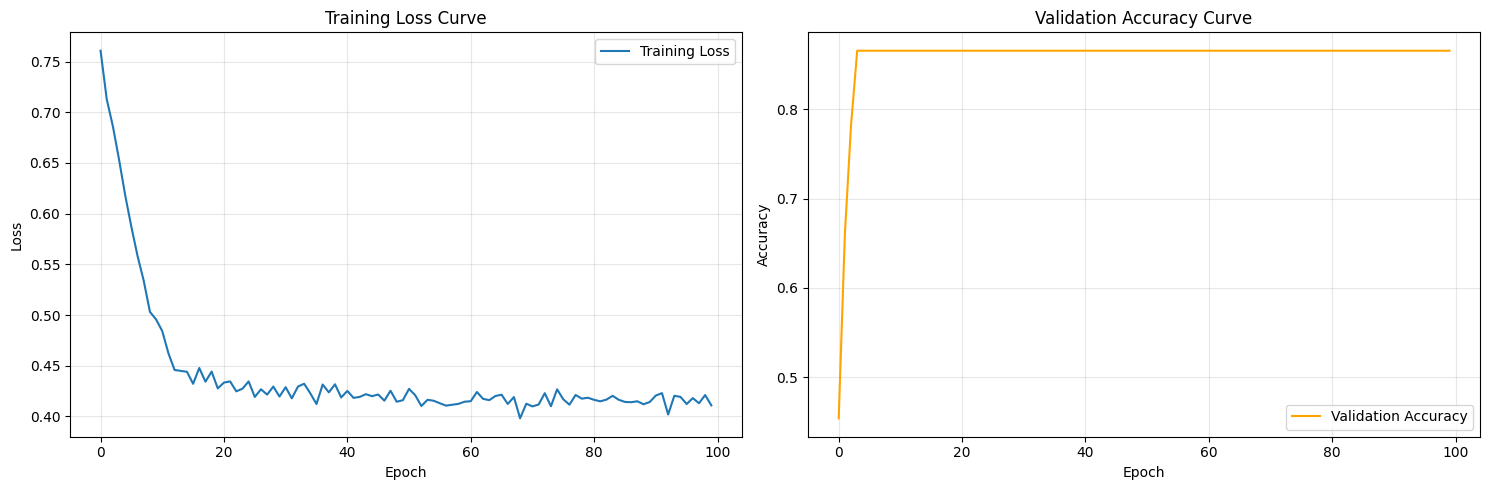

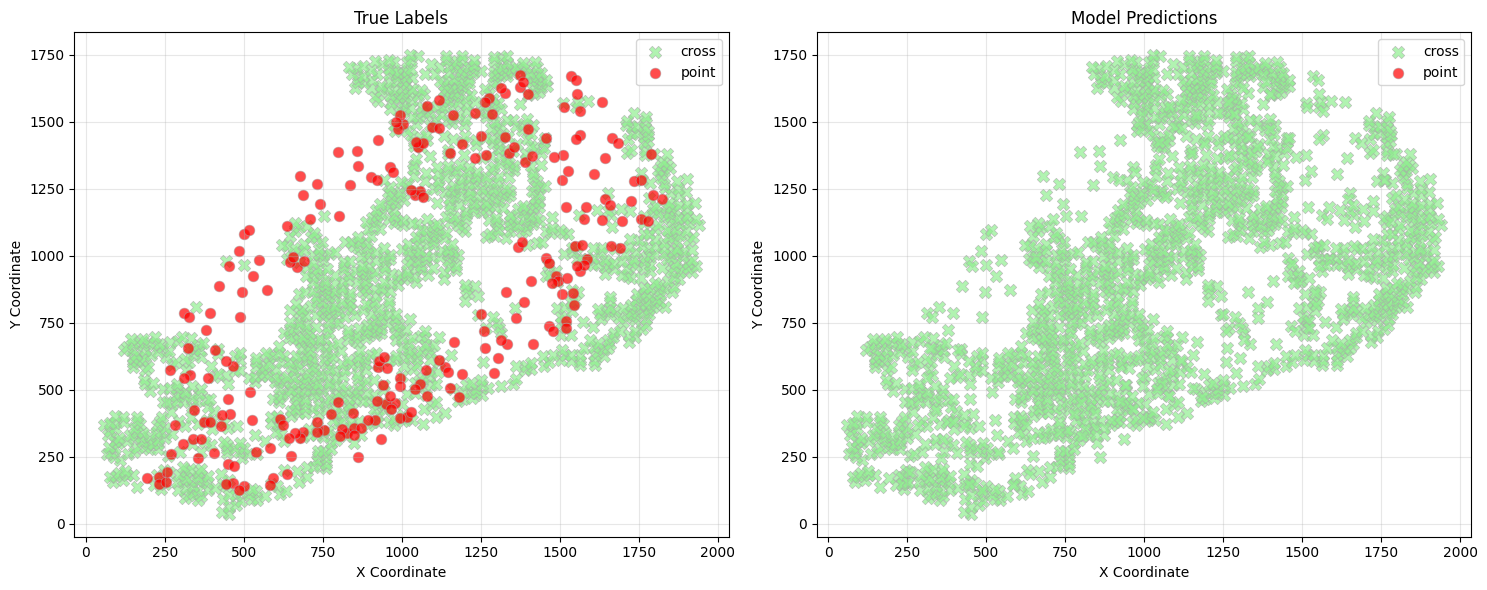

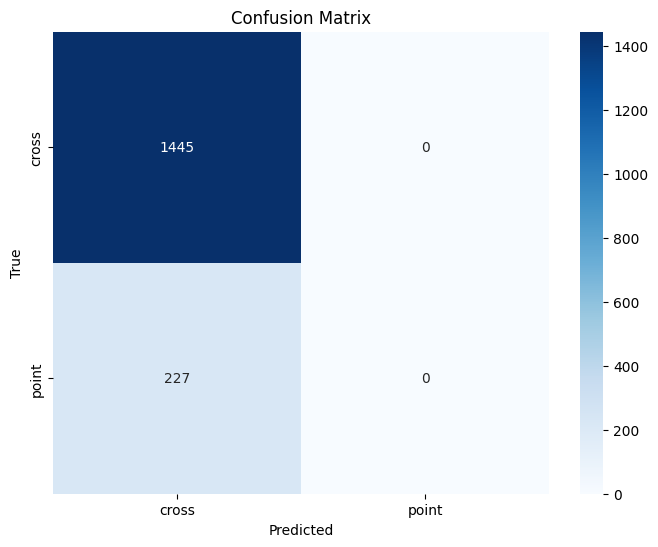

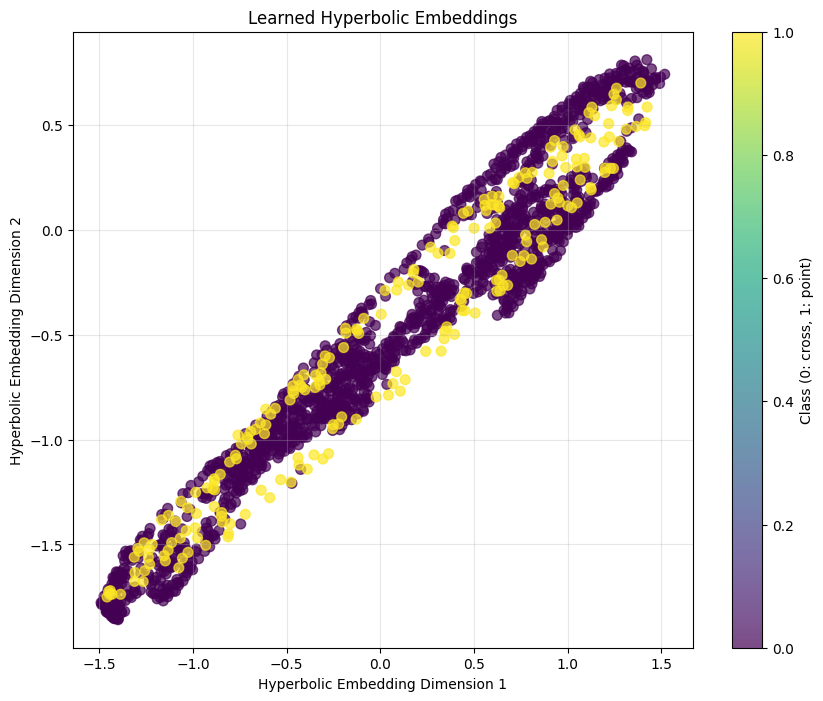

cross accuracy: 1.0000
point accuracy: 0.0000

Overall Test Accuracy: 0.8642

Classification Report:
              precision    recall  f1-score   support

       cross       0.86      1.00      0.93      1445
       point       0.00      0.00      0.00       227

    accuracy                           0.86      1672
   macro avg       0.43      0.50      0.46      1672
weighted avg       0.75      0.86      0.80      1672


Average prediction confidence: 0.8836
Confidence std: 0.0038


In [8]:
    # Load your data
    # Replace this with your actual data loading
    df = pd.read_csv('df_red_green_overlay.csv')

    print("Dataset Info:")
    print(f"Total samples: {len(df)}")
    print(f"Class distribution:\n{df['Type'].value_counts()}")
    print(f"X range: [{df['X'].min()}, {df['X'].max()}]")
    print(f"Y range: [{df['Y'].min()}, {df['Y'].max()}]")

    # Visualize original data
    plot_original_data(df)

    # Prepare data
    x, edge_index, y = prepare_data(df)

    print(f"\nGraph Info:")
    print(f"Nodes: {x.shape[0]}")
    print(f"Edges: {edge_index.shape[1]}")
    print(f"Features: {x.shape[1]}")

    # Visualize graph structure
    plot_graph_structure(df, edge_index, y)

    # Initialize model
    model = HyperbolicGNN(
        in_features=2,      # X, Y coordinates
        hidden_dim=16,      # Reduced for stability
        out_features=2,     # 2 classes: cross vs point
        curvature=0.5,      # Lower curvature for stability
        dropout=0.2
    )

    print(f"\nModel Architecture:")
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Train model
    print("\nTraining Hyperbolic GNN...")
    train_losses, val_accuracies, train_mask, val_mask = train_model(
        model, x, edge_index, y, epochs=100, lr=0.005
    )

    # Plot training curves
    plot_training_curves(train_losses, val_accuracies)

    # Make predictions and visualize
    predictions = plot_predictions(df, model, x, edge_index, y)

    # Confusion matrix
    plot_confusion_matrix(y.numpy(), predictions)

    # Plot hyperbolic embeddings
    plot_hyperbolic_embeddings(model, x, edge_index, y)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_out = model(x, edge_index)
        final_pred = final_out.argmax(dim=1)
        accuracy = (final_pred == y).float().mean()

        # Calculate precision for each class
        for class_idx, class_name in enumerate(['cross', 'point']):
            class_mask = y == class_idx
            if class_mask.sum() > 0:
                class_acc = (final_pred[class_mask] == y[class_mask]).float().mean()
                print(f"{class_name} accuracy: {class_acc:.4f}")

    print(f"\nOverall Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y.numpy(), predictions,
                              target_names=['cross', 'point']))

    # Analyze model confidence
    with torch.no_grad():
        probabilities = torch.exp(model(x, edge_index))
        confidence = probabilities.max(dim=1)[0]
        print(f"\nAverage prediction confidence: {confidence.mean():.4f}")
        print(f"Confidence std: {confidence.std():.4f}")


# Poincare Ball projection visualisation

Dataset Info:
Total samples: 1672
Class distribution:
Type
cross    1445
point     227
Name: count, dtype: int64

Training Hyperbolic GNN...
Epoch 000, Loss: 0.6322, Val Acc: 0.8657
Epoch 020, Loss: 0.4354, Val Acc: 0.8657
Epoch 040, Loss: 0.4217, Val Acc: 0.8657


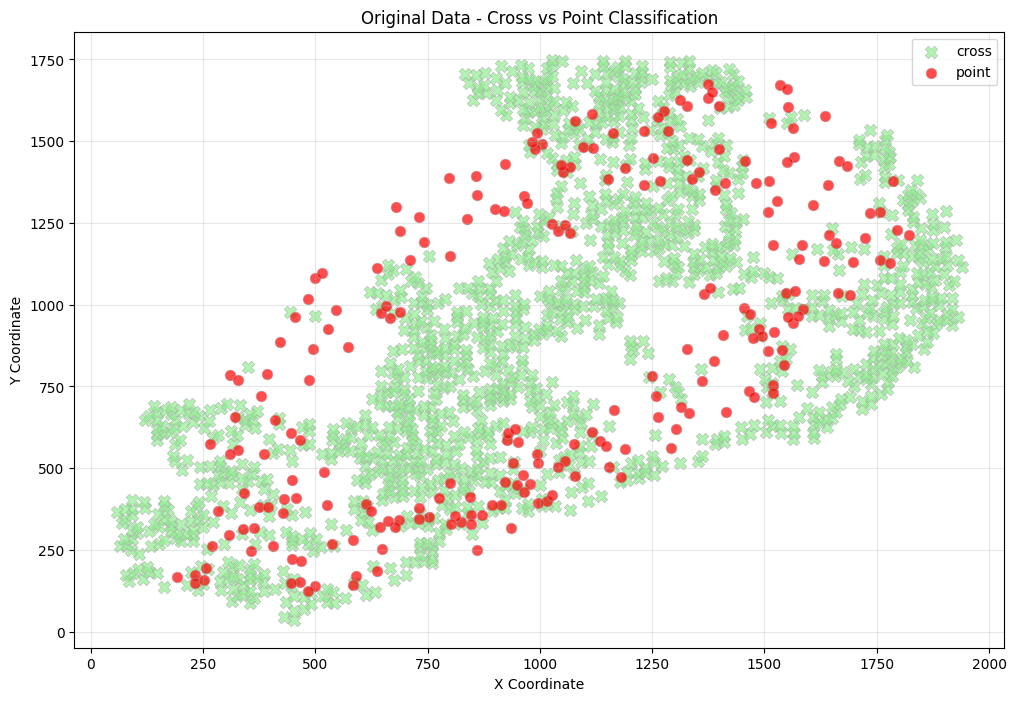


Visualizing Hyperbolic Projections...


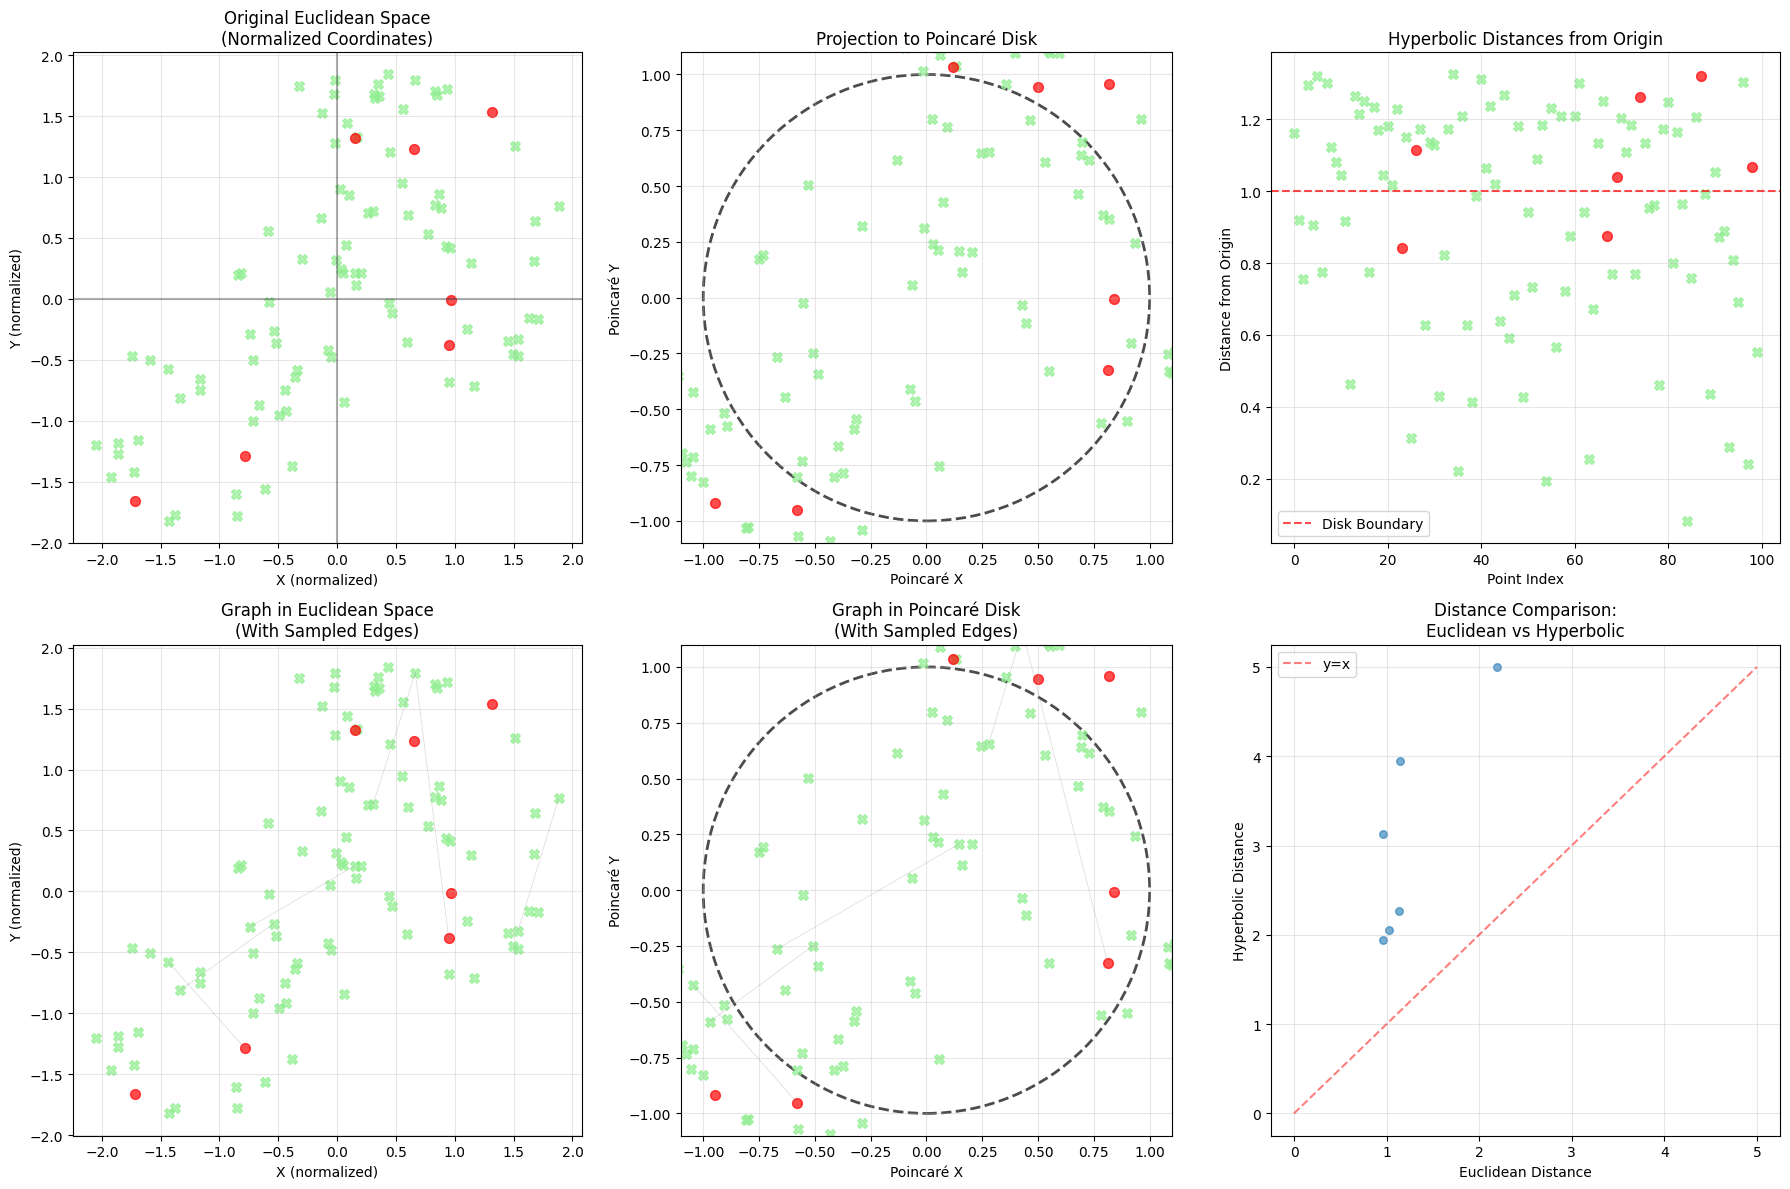


Visualizing Hyperbolic Geodesics...


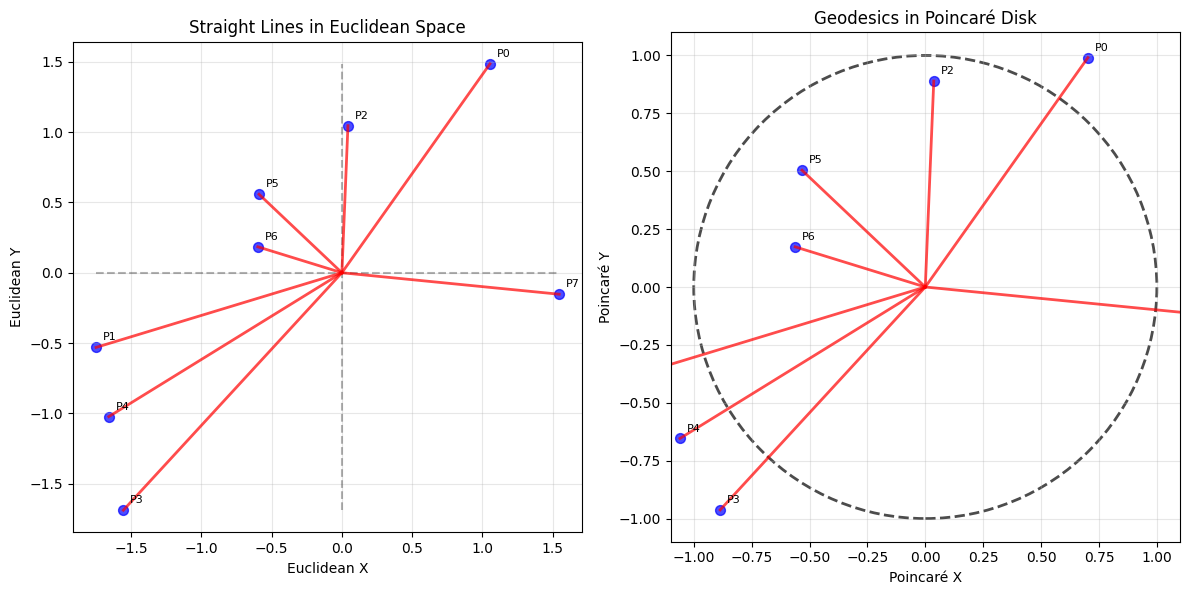


Visualizing Curvature Effects...


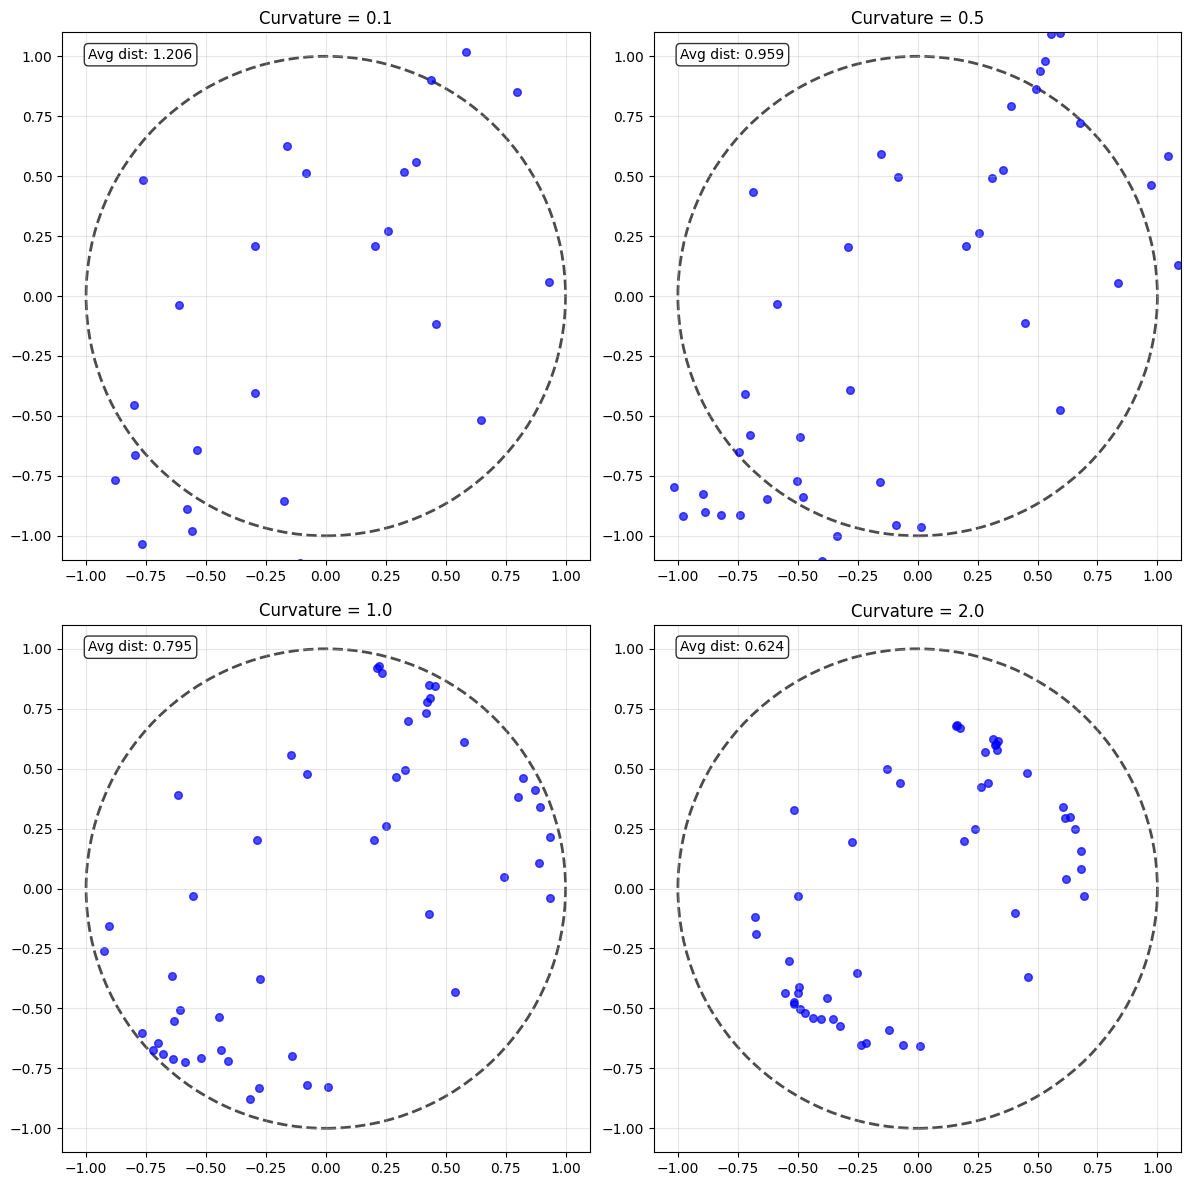


Visualizing Hierarchical Structure...


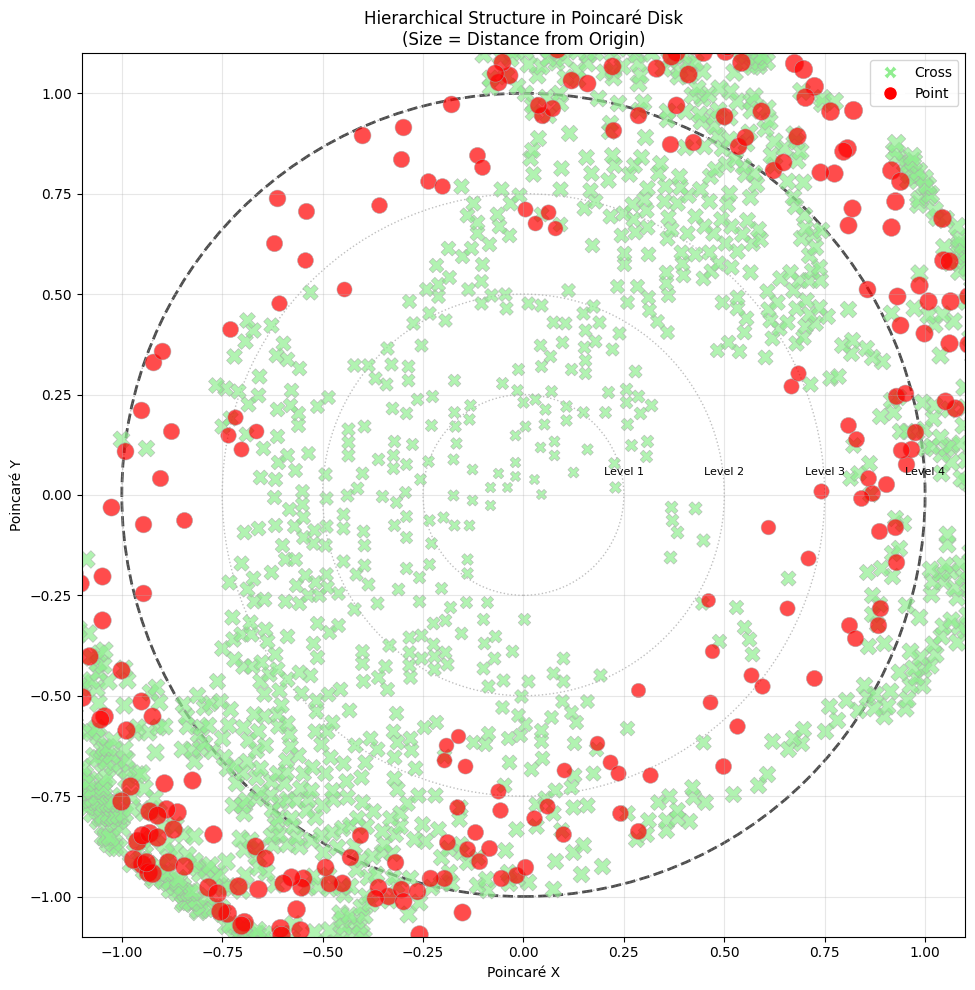


Hierarchical Analysis:
Level 1 (radius 0.00-0.25): 36 points (36 cross, 0 point)
Level 2 (radius 0.25-0.50): 128 points (128 cross, 0 point)
Level 3 (radius 0.50-0.75): 230 points (201 cross, 29 point)
Level 4 (radius 0.75-1.00): 399 points (324 cross, 75 point)


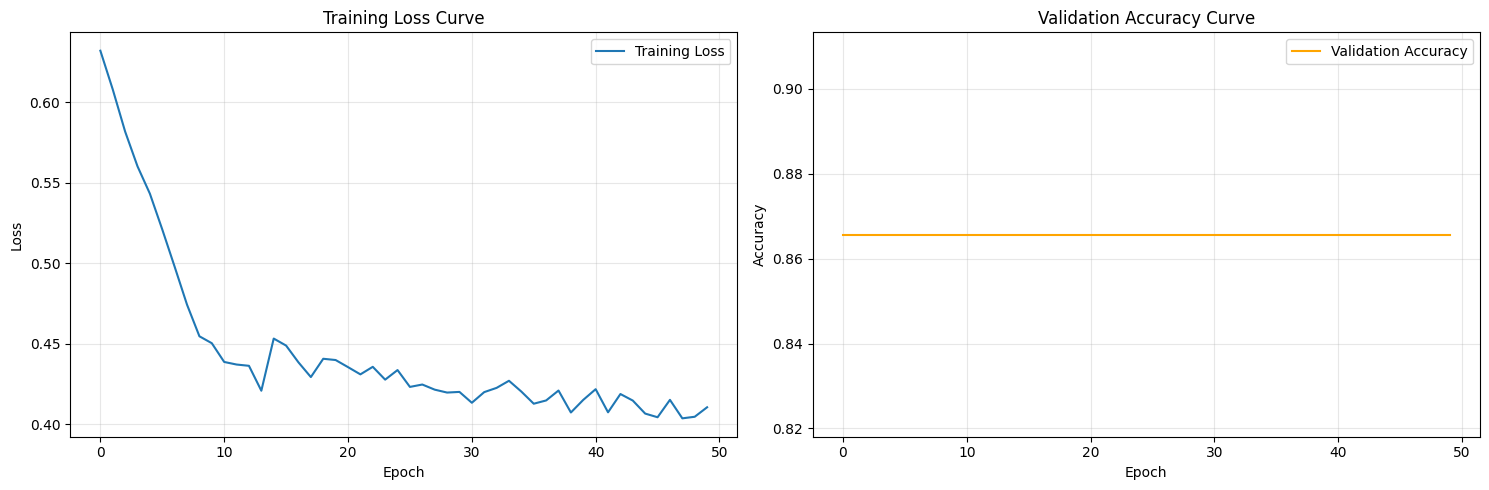


Overall Test Accuracy: 0.8642


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Circle

def plot_poincare_disk(ax, radius=1.0):
    """Plot the Poincaré disk boundary"""
    circle = Circle((0, 0), radius, fill=False, color='black', linewidth=2, linestyle='--', alpha=0.7)
    ax.add_patch(circle)
    return circle

def plot_hyperbolic_projection(model, x, edge_index, y, df, num_samples=None):
    """Visualize the projection from Euclidean to Poincaré disk"""

    if num_samples is not None and num_samples < len(x):
        indices = torch.randperm(len(x))[:num_samples]
        x_sample = x[indices]
        y_sample = y[indices]
        df_sample = df.iloc[indices.numpy()]
    else:
        x_sample = x
        y_sample = y
        df_sample = df

    model.eval()
    with torch.no_grad():
        # Project to Poincaré ball
        x_hyperbolic = model.manifold.expmap0(x_sample)

        # Convert to numpy for plotting
        x_euclidean = x_sample.numpy()
        x_poincare = x_hyperbolic.numpy()

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Original Euclidean space
    ax1 = axes[0, 0]
    colors = ['lightgreen' if label == 0 else 'red' for label in y_sample]
    markers = ['X' if label == 0 else 'o' for label in y_sample]

    for i, (point, color, marker) in enumerate(zip(x_euclidean, colors, markers)):
        ax1.scatter(point[0], point[1], c=color, marker=marker, s=50, alpha=0.7)

    ax1.set_xlabel('X (normalized)')
    ax1.set_ylabel('Y (normalized)')
    ax1.set_title('Original Euclidean Space\n(Normalized Coordinates)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 2. Poincaré disk projection
    ax2 = axes[0, 1]
    plot_poincare_disk(ax2)

    for i, (point, color, marker) in enumerate(zip(x_poincare, colors, markers)):
        ax2.scatter(point[0], point[1], c=color, marker=marker, s=50, alpha=0.7)

    ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel('Poincaré X')
    ax2.set_ylabel('Poincaré Y')
    ax2.set_title('Projection to Poincaré Disk')
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)

    # 3. Distance from origin in Poincaré disk
    ax3 = axes[0, 2]
    distances = np.linalg.norm(x_poincare, axis=1)

    for i, (dist, color, marker) in enumerate(zip(distances, colors, markers)):
        ax3.scatter(i, dist, c=color, marker=marker, s=50, alpha=0.7)

    ax3.set_xlabel('Point Index')
    ax3.set_ylabel('Distance from Origin')
    ax3.set_title('Hyperbolic Distances from Origin')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Disk Boundary')
    ax3.legend()

    # 4. Graph in Euclidean space (sample edges)
    ax4 = axes[1, 0]
    # Sample some edges for visualization
    edge_indices = torch.randperm(edge_index.shape[1])[:min(100, edge_index.shape[1])]

    for i in edge_indices:
        src, dst = edge_index[0][i].item(), edge_index[1][i].item()
        if src < len(x_sample) and dst < len(x_sample):
            src_point = x_euclidean[src]
            dst_point = x_euclidean[dst]
            ax4.plot([src_point[0], dst_point[0]], [src_point[1], dst_point[1]],
                    'gray', alpha=0.3, linewidth=0.5)

    for i, (point, color, marker) in enumerate(zip(x_euclidean, colors, markers)):
        ax4.scatter(point[0], point[1], c=color, marker=marker, s=50, alpha=0.7)

    ax4.set_xlabel('X (normalized)')
    ax4.set_ylabel('Y (normalized)')
    ax4.set_title('Graph in Euclidean Space\n(With Sampled Edges)')
    ax4.grid(True, alpha=0.3)

    # 5. Graph in Poincaré disk (sample edges)
    ax5 = axes[1, 1]
    plot_poincare_disk(ax5)

    # Draw hyperbolic geodesics (approximated as straight lines in this visualization)
    for i in edge_indices:
        src, dst = edge_index[0][i].item(), edge_index[1][i].item()
        if src < len(x_poincare) and dst < len(x_poincare):
            src_point = x_poincare[src]
            dst_point = x_poincare[dst]
            ax5.plot([src_point[0], dst_point[0]], [src_point[1], dst_point[1]],
                    'gray', alpha=0.3, linewidth=0.5)

    for i, (point, color, marker) in enumerate(zip(x_poincare, colors, markers)):
        ax5.scatter(point[0], point[1], c=color, marker=marker, s=50, alpha=0.7)

    ax5.set_xlim(-1.1, 1.1)
    ax5.set_ylim(-1.1, 1.1)
    ax5.set_xlabel('Poincaré X')
    ax5.set_ylabel('Poincaré Y')
    ax5.set_title('Graph in Poincaré Disk\n(With Sampled Edges)')
    ax5.set_aspect('equal')
    ax5.grid(True, alpha=0.3)

    # 6. Distance comparison
    ax6 = axes[1, 2]

    # Calculate Euclidean distances
    euclidean_dists = []
    hyperbolic_dists = []

    for i in edge_indices:
        src, dst = edge_index[0][i].item(), edge_index[1][i].item()
        if src < len(x_euclidean) and dst < len(x_euclidean):
            euclidean_dist = np.linalg.norm(x_euclidean[src] - x_euclidean[dst])
            hyperbolic_dist = model.manifold.dist(
                torch.tensor(x_poincare[src]).unsqueeze(0),
                torch.tensor(x_poincare[dst]).unsqueeze(0)
            ).item()

            euclidean_dists.append(euclidean_dist)
            hyperbolic_dists.append(hyperbolic_dist)

    ax6.scatter(euclidean_dists, hyperbolic_dists, alpha=0.6, s=30)
    ax6.set_xlabel('Euclidean Distance')
    ax6.set_ylabel('Hyperbolic Distance')
    ax6.set_title('Distance Comparison:\nEuclidean vs Hyperbolic')
    ax6.grid(True, alpha=0.3)

    # Add identity line for reference
    max_val = max(max(euclidean_dists), max(hyperbolic_dists))
    ax6.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x')
    ax6.legend()

    plt.tight_layout()
    plt.show()

    return x_poincare, x_euclidean

def plot_hyperbolic_geodesics(model, x, num_geodesics=5):
    """Plot hyperbolic geodesics from origin to several points"""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Select random points
    indices = torch.randperm(len(x))[:num_geodesics]
    x_sample = x[indices]

    model.eval()
    with torch.no_grad():
        x_hyperbolic = model.manifold.expmap0(x_sample)
        x_poincare = x_hyperbolic.numpy()

    # Plot in Euclidean space
    ax[0].scatter(x_sample[:, 0], x_sample[:, 1], c='blue', s=50, alpha=0.7)
    ax[0].plot([0, 0], [x_sample[:, 1].min(), x_sample[:, 1].max()], 'k--', alpha=0.3)
    ax[0].plot([x_sample[:, 0].min(), x_sample[:, 0].max()], [0, 0], 'k--', alpha=0.3)

    for i, point in enumerate(x_sample):
        ax[0].plot([0, point[0]], [0, point[1]], 'red', alpha=0.7, linewidth=2)
        ax[0].annotate(f'P{i}', (point[0], point[1]), xytext=(5, 5),
                      textcoords='offset points', fontsize=8)

    ax[0].set_xlabel('Euclidean X')
    ax[0].set_ylabel('Euclidean Y')
    ax[0].set_title('Straight Lines in Euclidean Space')
    ax[0].grid(True, alpha=0.3)
    ax[0].set_aspect('equal')

    # Plot in Poincaré disk
    plot_poincare_disk(ax[1])
    ax[1].scatter(x_poincare[:, 0], x_poincare[:, 1], c='blue', s=50, alpha=0.7)

    # Draw geodesics in Poincaré disk (approximated)
    for i, point in enumerate(x_poincare):
        # For visualization, we'll draw straight lines (actual geodesics are circular arcs)
        ax[1].plot([0, point[0]], [0, point[1]], 'red', alpha=0.7, linewidth=2)
        ax[1].annotate(f'P{i}', (point[0], point[1]), xytext=(5, 5),
                      textcoords='offset points', fontsize=8)

    ax[1].set_xlim(-1.1, 1.1)
    ax[1].set_ylim(-1.1, 1.1)
    ax[1].set_xlabel('Poincaré X')
    ax[1].set_ylabel('Poincaré Y')
    ax[1].set_title('Geodesics in Poincaré Disk')
    ax[1].grid(True, alpha=0.3)
    ax[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def plot_curvature_effect(model, x, curvatures=[0.1, 0.5, 1.0, 2.0]):
    """Visualize effect of different curvature values"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    # Select sample points
    indices = torch.randperm(len(x))[:min(50, len(x))]
    x_sample = x[indices]

    for idx, curvature in enumerate(curvatures):
        if idx >= len(axes):
            break

        # Create temporary manifold with different curvature
        temp_manifold = PoincareBall(c=curvature)

        with torch.no_grad():
            x_hyperbolic = temp_manifold.expmap0(x_sample)
            x_poincare = x_hyperbolic.numpy()

        plot_poincare_disk(axes[idx])
        axes[idx].scatter(x_poincare[:, 0], x_poincare[:, 1], c='blue', s=30, alpha=0.7)

        axes[idx].set_xlim(-1.1, 1.1)
        axes[idx].set_ylim(-1.1, 1.1)
        axes[idx].set_title(f'Curvature = {curvature}')
        axes[idx].set_aspect('equal')
        axes[idx].grid(True, alpha=0.3)

        # Calculate average distance from origin
        avg_dist = np.mean(np.linalg.norm(x_poincare, axis=1))
        axes[idx].text(0.05, 0.95, f'Avg dist: {avg_dist:.3f}',
                     transform=axes[idx].transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_hyperbolic_hierarchy(model, x, y, df, num_levels=3):
    """Visualize hierarchical structure in hyperbolic space"""
    model.eval()
    with torch.no_grad():
        x_hyperbolic = model.manifold.expmap0(x)
        x_poincare = x_hyperbolic.numpy()

    # Calculate distances from origin
    distances = np.linalg.norm(x_poincare, axis=1)

    # Create concentric circles for hierarchy levels
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_poincare_disk(ax)

    # Draw concentric circles
    for i in range(1, num_levels + 1):
        radius = i / num_levels
        circle = Circle((0, 0), radius, fill=False, color='gray',
                       linestyle=':', alpha=0.5, linewidth=1)
        ax.add_patch(circle)
        ax.text(radius, 0.05, f'Level {i}', fontsize=8, ha='center')

    # Color points by class and size by distance
    colors = ['lightgreen' if label == 0 else 'red' for label in y]
    markers = ['X' if label == 0 else 'o' for label in y]
    sizes = [50 + 100 * dist for dist in distances]  # Size proportional to distance

    for i, (point, color, marker, size) in enumerate(zip(x_poincare, colors, markers, sizes)):
        ax.scatter(point[0], point[1], c=color, marker=marker, s=size, alpha=0.7,
                 edgecolors='darkgray', linewidths=0.5)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('Poincaré X')
    ax.set_ylabel('Poincaré Y')
    ax.set_title('Hierarchical Structure in Poincaré Disk\n(Size = Distance from Origin)')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='lightgreen',
               markersize=10, label='Cross'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
               markersize=10, label='Point')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

    # Print hierarchical statistics
    print("\nHierarchical Analysis:")
    for i in range(num_levels):
        lower_bound = i / num_levels
        upper_bound = (i + 1) / num_levels
        level_mask = (distances >= lower_bound) & (distances < upper_bound)

        if level_mask.any():
            level_points = distances[level_mask]
            level_classes = y.numpy()[level_mask]

            cross_count = np.sum(level_classes == 0)
            point_count = np.sum(level_classes == 1)

            print(f"Level {i+1} (radius {lower_bound:.2f}-{upper_bound:.2f}): "
                  f"{len(level_points)} points "
                  f"({cross_count} cross, {point_count} point)")

# Update the main function to include these visualizations
def main_with_hyperbolic_visualizations():
    # Load your data
    df = pd.read_csv('df_red_green_overlay.csv')

    print("Dataset Info:")
    print(f"Total samples: {len(df)}")
    print(f"Class distribution:\n{df['Type'].value_counts()}")

    # Prepare data
    x, edge_index, y = prepare_data(df)

    # Initialize and train model (using the previous training code)
    model = HyperbolicGNN(
        in_features=2,
        hidden_dim=16,
        out_features=2,
        curvature=0.5,
        dropout=0.2
    )

    print("\nTraining Hyperbolic GNN...")
    train_losses, val_accuracies, train_mask, val_mask = train_model(
        model, x, edge_index, y, epochs=50, lr=0.005
    )

    # Original data visualization
    plot_original_data(df)

    # Comprehensive hyperbolic projections
    print("\nVisualizing Hyperbolic Projections...")
    x_poincare, x_euclidean = plot_hyperbolic_projection(model, x, edge_index, y, df, num_samples=100)

    # Geodesics visualization
    print("\nVisualizing Hyperbolic Geodesics...")
    plot_hyperbolic_geodesics(model, x, num_geodesics=8)

    # Curvature effect
    print("\nVisualizing Curvature Effects...")
    plot_curvature_effect(model, x)

    # Hierarchical structure
    print("\nVisualizing Hierarchical Structure...")
    plot_hyperbolic_hierarchy(model, x, y, df, num_levels=4)

    # Training curves
    plot_training_curves(train_losses, val_accuracies)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_out = model(x, edge_index)
        final_pred = final_out.argmax(dim=1)
        accuracy = (final_pred == y).float().mean()

    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

# Run the enhanced visualization
if __name__ == "__main__":
    main_with_hyperbolic_visualizations()